# Regression by Minimizing Cost Function

This notebook demonstrates how to do a regression test by minimizing a cost function. You can use any standard performance matric, like MSE, RMSE, Log-Likelihood. Or you can write your own. 

The steps to do so are very simple and almost the same for any algorithm. Import your data, clean it, and then define a cost function. Iterate to find the coefficients that minimize -maximize- the function. 
I'm going to use the built-in minimize function in `Scipy` library. 

As usual, let's start by importing the libraries we're goign to use in this exercise

In [16]:
import numpy as np
import scipy.optimize as optim
import scipy.stats as st
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

For this purpose I'm going to generate a univariate dataset and split it into test and training before we do anything else

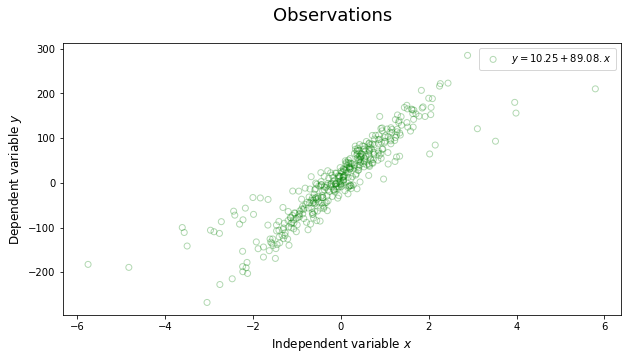

In [17]:
# Generate the data
N = 500
BIAS = 10.25
NOISE = 20
SEED = 124
FEATURES = 1
TEST_SIZE = 0.2
OUTLIERS = 0.1 #propotion of needed outliers
SCALE = 2.5 #outliers scaling factor
np.random.seed(SEED)

X,Y,b0 = make_regression(N,FEATURES, bias=BIAS, noise=NOISE, coef=True, random_state=SEED,
                        tail_strength=0.8)

# create outliers within features
X[np.random.choice(range(len(X)), size=int(OUTLIERS*len(X)))] *= SCALE

x,x_test,y,y_test = train_test_split(X,Y, test_size=TEST_SIZE, random_state=SEED)

x_mat = np.column_stack([np.ones(len(x)),x])
x_test_mat = np.column_stack([np.ones(len(x_test)),x_test])

# plot the data
fig = plt.figure(figsize=(10,5))
fig.suptitle('Observations', fontsize=18)
plt.scatter(x,y,marker='o', edgecolors='green', facecolors='None', alpha=0.3, label=f'$y={BIAS} + {b0:.2f}.x$');
plt.xlabel('Independent variable $x$', fontsize=12)
plt.ylabel('Dependent variable $y$', fontsize=12)
plt.legend()
plt.show()

### Benchmark
The true parameters I'm going to measure the optimizers against are

In [18]:
print(f'True Intercept: {BIAS}, True Coefficient: {b0:.3f}')
b = [BIAS, b0]

True Intercept: 10.25, True Coefficient: 89.076


## 1. MSE:

Our goal is to find the intercept $\beta_0$ and the coefficient $\beta_1$ that minimizes 'some' error term. First we take the Mean Squared Error, which is the most popular in regression problems and theoretically should match what get from Ordinary Least Square (OLS). So we have a reference point to validate our results.  


In [19]:
# MSE function
def mse(bs,y,x):
    y_hat = x@bs
    return np.mean(np.power(y-y_hat,2))

algorithms = []
mse_optim = optim.minimize(mse, x0=[1.,1.], args=(y,x_mat))
mse_optim.name = 'MSE'
algorithms.append(mse_optim)
mse_optim

      fun: 1459.6345555098535
 hess_inv: array([[0.50065644, 0.01469421],
       [0.01469421, 0.32933946]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     name: 'MSE'
     nfev: 27
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([11.73743123, 64.36438028])

## 2. RMSE:


In [20]:
def rmse(bs,y,x):
    return np.sqrt(mse(bs,y,x))

In [21]:
rmse_optim = optim.minimize(rmse,x0=[1.,1.],args=(y,x_mat))
rmse_optim.name = 'RMSE'
algorithms.append(rmse_optim)
rmse_optim

      fun: 38.20516399009238
 hess_inv: array([[38.18884435,  1.14874487],
       [ 1.14874487, 24.88168643]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     name: 'RMSE'
     nfev: 48
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([11.73742556, 64.36437807])

## 3. MAE:
Mean Absolute Error is the mean of the absolute difference between the true and predicted $y$ values. Unlike the Mean Square Error family, MAE is less sensitive to big errors values (i.e. outliers in the data).

In [22]:
def mae(bs,y,x):
    return np.mean(abs(y-x@bs))

In [23]:
mae_optim = optim.minimize(mae, x0=[1.,1.], args=(y,x_mat))
algorithms.append(mae_optim)
mae_optim.name = 'MAE'
mae_optim

      fun: 26.14598207660234
 hess_inv: array([[11.05488907,  5.72118231],
       [ 5.72118231, 29.72497189]])
      jac: array([0.       , 0.0006876])
  message: 'Desired error not necessarily achieved due to precision loss.'
     name: 'MAE'
     nfev: 190
      nit: 9
     njev: 62
   status: 2
  success: False
        x: array([11.66439212, 80.70520963])

## 4. Maximum Likelihood $w_{ML}$

The asumption is that the data points were generated from Gaussian distribution with mean $\mu$ and standard deviation $\sigma$. Or it can be expressed as the following notation: $y\sim (Xw|\sigma^2 I)$

Maximum likelihood is a process that finds the mean and standard deviation of the normal distribution that best describes the observations

In [24]:
# bs is a vector that contains the intercept b0 and 
# define the log-likelihood function (minimize the negative = maximize likelihood)
def logit(bs,y,X):
    if bs[-1] < 0: return inf
    lik = st.norm.pdf(y,loc=X@bs,scale=bs[-1])
    if all(v==0 for v in lik):return inf
    log_lik = np.log(lik[np.nonzero(lik)])
    return -sum(log_lik)

In [25]:
logit_optim = optim.minimize(logit, x0=[10.,10.], args=(y,x_mat))
algorithms.append(logit_optim)
logit_optim.name = 'Likelihood'
logit_optim

      fun: 2073.1916313153706
 hess_inv: array([[ 8.78052674, -0.82410885],
       [-0.82410885,  0.60654156]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     name: 'Likelihood'
     nfev: 108
      nit: 23
     njev: 36
   status: 0
  success: True
        x: array([11.17796794, 51.82056862])

### Summary

Plotting everything to visualize the regression lines side by side along with training data points.

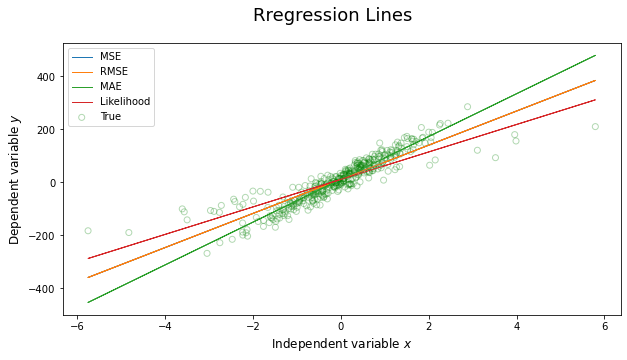

In [26]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Rregression Lines', fontsize=18)
ax = fig.add_subplot(111)
ax.scatter(x,y,marker='o', edgecolors='green', facecolors='None', alpha=0.3, label='True')

for algo in algorithms:
    ax.plot(x, x_mat@algo.x, label=algo.name, lw=1)
    
ax.set_xlabel('Independent variable $x$', fontsize=12)
ax.set_ylabel('Dependent variable $y$', fontsize=12)
ax.legend()
plt.show()

**Conclusion**:  the plot shows how MAE based regression is less sensitive to large errors caused by the outliers in the data, while MSE and RMSE lines try to fit them by decreasing their slops